# Model Evaluation

In this notebook, I will test multiple model and evaluate to choose the best one.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

In [39]:
X = pd.read_pickle('PKL/X_train.pkl')
y = pd.read_pickle('PKL/Y_train.pkl')

## Train/Test Split
I'm actually going to split my train data once more. It's because this is a competition dataset and I actually don't have the 'test' score result. So I will use the initial test features as a holdout set, and make another subset of train/test for validations.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

In [41]:
# One Hot Encoding 
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

In [45]:
# Check if they have the same features
if X_train_ohe.shape[1] != X_test_ohe.shape[1]:
    print([x for x in X_train_ohe.columns if x not in X_test_ohe.columns])
    print([x for x in X_test_ohe.columns if x not in X_train_ohe.columns])
else: 
    print ('Good to go')

Good to go


In [32]:
# If they are not the same, add the column with 0s and fix the order
# X_test_ohe = X_test_ohe[X_train_ohe.columns]

## Class Imbalance Issue
Our dataset has high class imbalance issue. We will deal with this by setting the class weight within each model.  
For modeling process using SMOTE, please refer to the (name of notebook). 

## Evaluation Metrics
Our target is multi-class with imbalance issue. We will use the weighted f1 score to capture the predictive performance for each classes. It calculates the f1 score for each class and find the average weighted by the number of positive cases in each class. For an additional measure to account for the class imbalance, I will use balanced accuracy score. This computes the average accuracy score weighted by the inverse prevalence of the true class.  

We rather want to overpredict the needs repair or non functional cases than the functional cases as the condition of the well is crucial for survival of surrounding population. Specifically, we want the recall of the non functional and needs repair cases to be high. So I will also look at this using the classification report.

Additionally we will plot confusion matrix and breakdown of the performance using classification report to understand some of the scores better.

In [91]:
from sklearn.metrics import f1_score, balanced_accuracy_score, plot_confusion_matrix, classification_report

## Dummy Classifier
I'll create a dummy classifier as a baseline score.

In [92]:
#keeping score
score_keeper = {}

In [93]:
from sklearn.dummy import DummyClassifier
dummyc = DummyClassifier(strategy = 'stratified') # using the default stratified strategy
dummyc.fit(X_train_ohe, y_train)
y_pred = dummyc.predict(X_test_ohe)

f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)
print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['baseline'] = (f1_test, acc_test)


Test F1 score:  0.447 / Test Accuracy:  0.336


                         precision    recall  f1-score   support

             functional       0.54      0.54      0.54      4822
functional needs repair       0.08      0.08      0.08       678
         non functional       0.39      0.39      0.39      3410

               accuracy                           0.45      8910
              macro avg       0.34      0.34      0.34      8910
           weighted avg       0.45      0.45      0.45      8910



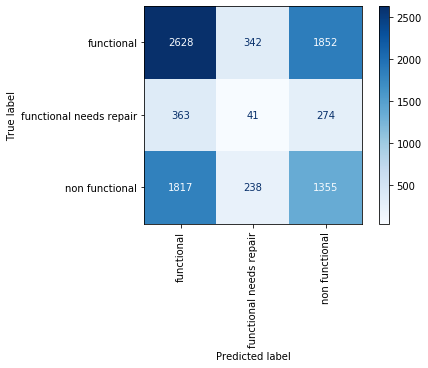

In [94]:
plot_confusion_matrix(dummyc, X_test_ohe, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Our stratified dummy classifier shows the weighted F1 score of 44.2% but less balanced accuracy. Dummy classifier is consistently wrong on all cases but recall for minority classes are especially bad.

## KNN
First, I will run K-Nearest Neighbors using GridSearchCV. 

### Standardization
For KNN, I will standardize all feature values.

In [80]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_ohe)
X_test_scaled = scale.transform(X_test_ohe)

Then I'll try to find the optimal hyperparameters using GridSearchCV.

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [82]:
params = {
    'n_neighbors': range(1, 16, 2), # setting K
}

knc = KNeighborsClassifier(weights = 'distance') 
knc_g = GridSearchCV(knc, params, cv = 5, scoring = 'f1_weighted', verbose = 1, n_jobs = -1)
knc_g.fit(X_train_scaled, y_train)
print(knc_g.best_params_, ': ', knc_g.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 16.7min finished


{'n_neighbors': 9} :  0.7364056869483134


In [83]:
# saving the model 
mod = open('PKL/knn_gsc.pkl', 'wb')
pickle.dump(knc_g.best_estimator_, mod)
mod.close()

In [95]:
# KNN performance on the test set
y_pred = knc_g.best_estimator_.predict(X_test_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_gsc'] = (f1_test, acc_test)

Test F1 score:  0.749 / Test Accuracy:  0.623


                         precision    recall  f1-score   support

             functional       0.78      0.83      0.80      4822
functional needs repair       0.45      0.30      0.36       678
         non functional       0.76      0.74      0.75      3410

               accuracy                           0.75      8910
              macro avg       0.66      0.62      0.64      8910
           weighted avg       0.75      0.75      0.75      8910



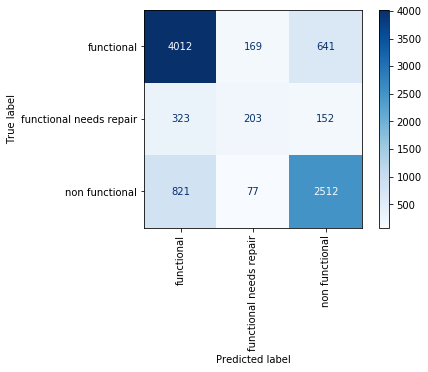

In [96]:
plot_confusion_matrix(knc_g.best_estimator_, X_test_scaled, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Recall rate improved much but it's still pretty low for needs repair case.

### Optimization Method
Now I want to try different optimization method to make sure I have the best hyperparmeter for KNN. This time I'll use optuna to explore even more hyperparameters. I'll cap the time to what it took to run the GridSearch above.

In [97]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
def find_hyperp_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 31)
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    leaf_size = trial.suggest_int('leaf_size', 2, 60)
    p = trial.suggest_categorical('p', [1, 2])
    knc = KNeighborsClassifier(weights = 'distance', 
                             n_neighbors = n_neighbors, 
                             algorithm = algorithm, 
                             leaf_size = leaf_size, 
                             p = p)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train_scaled, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = -1))
    return (score)

knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(find_hyperp_KNN, timeout = 16.7*60)

In [ ]:
# saving the study 
mod = open('PKL/knn_study.pkl', 'wb')
pickle.dump(knn_study, mod)
mod.close()

In [ ]:
knn_study.best_params

In [35]:
# Testing the best params on the test set
knc_opt = KNeighborsClassifier(algorithm = 'kd_tree', leaf_size = 18, n_neighbors=7, p =1, weights = 'distance')
knc_opt.fit(X_train_scaled, y_train)

y_pred = knc_opt.predict(X_test_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_opt'] = (f1_test, acc_test)

Test F1 score:  0.535 / Test Accuracy:  0.546


In [ ]:
plot_confusion_matrix(knc_opt, X_test_scaled, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

## Random Forest 
Since Optuna performance was better above, now I'll run random forest using Optuna.

In [19]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [20]:
def find_hyperparam_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 0, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_features = trial.suggest_int('max_features', 2, 20)
    rfc = RandomForestClassifier(oob_score = True, 
                             n_estimators = n_estimators, 
                             max_depth = max_depth, 
                             min_samples_split = min_samples_split, 
                             min_samples_leaf = min_samples_leaf, 
                             criterion = criterion, 
                             class_weight = class_weight, 
                             max_features = max_features)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(rfc, X_train_ohe, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = -1))
    return (score)

rfc_study = optuna.create_study(direction='maximize')
rfc_study.optimize(find_hyperparam_rf, timeout = 12600)

[W 2020-08-18 23:54:47,665] Trial 0 failed, because the objective function returned nan.
[W 2020-08-18 23:54:49,041] Trial 1 failed, because the objective function returned nan.
[W 2020-08-18 23:54:50,482] Trial 2 failed, because the objective function returned nan.
[I 2020-08-18 23:55:00,465] Trial 3 finished with value: 0.6264966564517171 and parameters: {'n_estimators': 134, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 4}. Best is trial 3 with value: 0.6264966564517171.
[I 2020-08-18 23:55:07,818] Trial 4 finished with value: 0.630982019682325 and parameters: {'n_estimators': 89, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 7}. Best is trial 4 with value: 0.630982019682325.
[I 2020-08-18 23:55:23,855] Trial 5 finished with value: 0.6374768694452265 and parameters: {'n_estimators': 192, 'max_depth': 6, 'min_samples_sp

[I 2020-08-19 00:02:33,761] Trial 42 finished with value: 0.6847742579091934 and parameters: {'n_estimators': 57, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 15, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 17}. Best is trial 21 with value: 0.69254713436226.
[I 2020-08-19 00:03:07,363] Trial 43 finished with value: 0.6913199547008795 and parameters: {'n_estimators': 297, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 15, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 21 with value: 0.69254713436226.
[W 2020-08-19 00:03:08,817] Trial 44 failed, because the objective function returned nan.
[I 2020-08-19 00:03:36,557] Trial 45 finished with value: 0.6841442032530802 and parameters: {'n_estimators': 259, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 14, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 18}. Best is trial 21 with value: 0.69254713436226.
[

[I 2020-08-19 00:09:28,246] Trial 93 finished with value: 0.6841956885476908 and parameters: {'n_estimators': 181, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 18}. Best is trial 73 with value: 0.6976187198790964.
[W 2020-08-19 00:09:29,666] Trial 94 failed, because the objective function returned nan.
[I 2020-08-19 00:09:45,679] Trial 95 finished with value: 0.6916219162762086 and parameters: {'n_estimators': 157, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 16}. Best is trial 73 with value: 0.6976187198790964.
[W 2020-08-19 00:09:47,063] Trial 96 failed, because the objective function returned nan.
[W 2020-08-19 00:09:48,443] Trial 97 failed, because the objective function returned nan.
[I 2020-08-19 00:09:59,700] Trial 98 finished with value: 0.6703569614655253 and parameters: {'n_estimators': 121, 'max_depth': 6, 'm

[I 2020-08-19 00:15:06,183] Trial 135 finished with value: 0.6884148157098829 and parameters: {'n_estimators': 202, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 19}. Best is trial 73 with value: 0.6976187198790964.
[I 2020-08-19 00:15:29,993] Trial 136 finished with value: 0.6955234936048325 and parameters: {'n_estimators': 214, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 73 with value: 0.6976187198790964.
[I 2020-08-19 00:15:54,859] Trial 137 finished with value: 0.6974704189177282 and parameters: {'n_estimators': 227, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 73 with value: 0.6976187198790964.
[I 2020-08-19 00:16:19,063] Trial 138 finished with value: 0.6896360143364981 and parameters: {'n_estimato

[I 2020-08-19 00:26:04,942] Trial 163 finished with value: 0.7025389419410214 and parameters: {'n_estimators': 267, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 18}. Best is trial 163 with value: 0.7025389419410214.
[I 2020-08-19 00:26:30,877] Trial 164 finished with value: 0.6991734257385029 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 17}. Best is trial 163 with value: 0.7025389419410214.
[I 2020-08-19 00:26:57,929] Trial 165 finished with value: 0.6981692538562282 and parameters: {'n_estimators': 261, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 17}. Best is trial 163 with value: 0.7025389419410214.
[I 2020-08-19 00:27:23,898] Trial 166 finished with value: 0.6992606400549838 and parameters: {'n_estim

[W 2020-08-19 00:37:22,428] Trial 195 failed, because the objective function returned nan.
[W 2020-08-19 00:37:23,887] Trial 196 failed, because the objective function returned nan.
[W 2020-08-19 00:37:25,334] Trial 197 failed, because the objective function returned nan.
[W 2020-08-19 00:37:26,783] Trial 198 failed, because the objective function returned nan.
[W 2020-08-19 00:37:28,256] Trial 199 failed, because the objective function returned nan.
[W 2020-08-19 00:37:29,705] Trial 200 failed, because the objective function returned nan.
[W 2020-08-19 00:37:31,186] Trial 201 failed, because the objective function returned nan.
[W 2020-08-19 00:37:32,704] Trial 202 failed, because the objective function returned nan.
[W 2020-08-19 00:37:34,186] Trial 203 failed, because the objective function returned nan.
[W 2020-08-19 00:37:35,723] Trial 204 failed, because the objective function returned nan.
[W 2020-08-19 00:37:37,192] Trial 205 failed, because the objective function returned nan.

[W 2020-08-19 00:41:20,886] Trial 273 failed, because the objective function returned nan.
[W 2020-08-19 00:41:22,325] Trial 274 failed, because the objective function returned nan.
[W 2020-08-19 00:41:23,786] Trial 275 failed, because the objective function returned nan.
[W 2020-08-19 00:41:25,235] Trial 276 failed, because the objective function returned nan.
[W 2020-08-19 00:41:26,683] Trial 277 failed, because the objective function returned nan.
[W 2020-08-19 00:41:28,120] Trial 278 failed, because the objective function returned nan.
[W 2020-08-19 00:41:29,580] Trial 279 failed, because the objective function returned nan.
[W 2020-08-19 00:41:31,022] Trial 280 failed, because the objective function returned nan.
[I 2020-08-19 00:41:56,405] Trial 281 finished with value: 0.6995342578602769 and parameters: {'n_estimators': 246, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 18}. Best is trial 163 with 

[W 2020-08-19 00:44:53,369] Trial 353 failed, because the objective function returned nan.
[W 2020-08-19 00:44:54,851] Trial 354 failed, because the objective function returned nan.
[W 2020-08-19 00:44:56,347] Trial 355 failed, because the objective function returned nan.
[W 2020-08-19 00:44:57,824] Trial 356 failed, because the objective function returned nan.
[W 2020-08-19 00:44:59,353] Trial 357 failed, because the objective function returned nan.
[W 2020-08-19 00:45:00,826] Trial 358 failed, because the objective function returned nan.
[W 2020-08-19 00:45:02,253] Trial 359 failed, because the objective function returned nan.
[W 2020-08-19 00:45:03,694] Trial 360 failed, because the objective function returned nan.
[W 2020-08-19 00:45:05,182] Trial 361 failed, because the objective function returned nan.
[W 2020-08-19 00:45:06,653] Trial 362 failed, because the objective function returned nan.
[W 2020-08-19 00:45:08,130] Trial 363 failed, because the objective function returned nan.

[W 2020-08-19 00:47:40,343] Trial 438 failed, because the objective function returned nan.
[W 2020-08-19 00:47:41,834] Trial 439 failed, because the objective function returned nan.
[W 2020-08-19 00:47:43,287] Trial 440 failed, because the objective function returned nan.
[W 2020-08-19 00:47:44,767] Trial 441 failed, because the objective function returned nan.
[W 2020-08-19 00:47:46,194] Trial 442 failed, because the objective function returned nan.
[W 2020-08-19 00:47:47,681] Trial 443 failed, because the objective function returned nan.
[W 2020-08-19 00:47:49,167] Trial 444 failed, because the objective function returned nan.
[W 2020-08-19 00:47:50,607] Trial 445 failed, because the objective function returned nan.
[W 2020-08-19 00:47:52,080] Trial 446 failed, because the objective function returned nan.
[W 2020-08-19 00:47:53,540] Trial 447 failed, because the objective function returned nan.
[W 2020-08-19 00:47:55,007] Trial 448 failed, because the objective function returned nan.

[W 2020-08-19 00:50:33,362] Trial 523 failed, because the objective function returned nan.
[W 2020-08-19 00:50:34,810] Trial 524 failed, because the objective function returned nan.
[W 2020-08-19 00:50:36,280] Trial 525 failed, because the objective function returned nan.
[W 2020-08-19 00:50:37,834] Trial 526 failed, because the objective function returned nan.
[W 2020-08-19 00:50:39,320] Trial 527 failed, because the objective function returned nan.
[W 2020-08-19 00:50:40,762] Trial 528 failed, because the objective function returned nan.
[W 2020-08-19 00:50:42,190] Trial 529 failed, because the objective function returned nan.
[W 2020-08-19 00:50:43,647] Trial 530 failed, because the objective function returned nan.
[W 2020-08-19 00:50:45,089] Trial 531 failed, because the objective function returned nan.
[W 2020-08-19 00:50:46,541] Trial 532 failed, because the objective function returned nan.
[W 2020-08-19 00:50:48,019] Trial 533 failed, because the objective function returned nan.

[W 2020-08-19 00:53:47,402] Trial 606 failed, because the objective function returned nan.
[W 2020-08-19 00:53:48,867] Trial 607 failed, because the objective function returned nan.
[W 2020-08-19 00:53:50,328] Trial 608 failed, because the objective function returned nan.
[W 2020-08-19 00:53:51,776] Trial 609 failed, because the objective function returned nan.
[W 2020-08-19 00:53:53,204] Trial 610 failed, because the objective function returned nan.
[W 2020-08-19 00:53:54,641] Trial 611 failed, because the objective function returned nan.
[W 2020-08-19 00:53:56,119] Trial 612 failed, because the objective function returned nan.
[W 2020-08-19 00:53:57,615] Trial 613 failed, because the objective function returned nan.
[W 2020-08-19 00:53:59,068] Trial 614 failed, because the objective function returned nan.
[W 2020-08-19 00:54:00,481] Trial 615 failed, because the objective function returned nan.
[W 2020-08-19 00:54:01,905] Trial 616 failed, because the objective function returned nan.

[W 2020-08-19 00:56:19,371] Trial 693 failed, because the objective function returned nan.
[W 2020-08-19 00:56:20,827] Trial 694 failed, because the objective function returned nan.
[W 2020-08-19 00:56:22,298] Trial 695 failed, because the objective function returned nan.
[W 2020-08-19 00:56:23,745] Trial 696 failed, because the objective function returned nan.
[W 2020-08-19 00:56:25,190] Trial 697 failed, because the objective function returned nan.
[W 2020-08-19 00:56:26,629] Trial 698 failed, because the objective function returned nan.
[I 2020-08-19 00:56:52,056] Trial 699 finished with value: 0.6980379030148918 and parameters: {'n_estimators': 234, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 19}. Best is trial 163 with value: 0.7025389419410214.
[W 2020-08-19 00:56:53,536] Trial 700 failed, because the objective function returned nan.
[W 2020-08-19 00:56:55,012] Trial 701 failed, because the object

[W 2020-08-19 00:59:56,580] Trial 773 failed, because the objective function returned nan.
[W 2020-08-19 00:59:58,044] Trial 774 failed, because the objective function returned nan.
[W 2020-08-19 00:59:59,505] Trial 775 failed, because the objective function returned nan.
[W 2020-08-19 01:00:01,009] Trial 776 failed, because the objective function returned nan.
[W 2020-08-19 01:00:02,512] Trial 777 failed, because the objective function returned nan.
[W 2020-08-19 01:00:03,930] Trial 778 failed, because the objective function returned nan.
[W 2020-08-19 01:00:05,437] Trial 779 failed, because the objective function returned nan.
[W 2020-08-19 01:00:06,923] Trial 780 failed, because the objective function returned nan.
[W 2020-08-19 01:00:08,409] Trial 781 failed, because the objective function returned nan.
[W 2020-08-19 01:00:09,883] Trial 782 failed, because the objective function returned nan.
[W 2020-08-19 01:00:11,366] Trial 783 failed, because the objective function returned nan.

[W 2020-08-19 01:02:49,335] Trial 858 failed, because the objective function returned nan.
[W 2020-08-19 01:02:50,827] Trial 859 failed, because the objective function returned nan.
[W 2020-08-19 01:02:52,277] Trial 860 failed, because the objective function returned nan.
[W 2020-08-19 01:02:53,752] Trial 861 failed, because the objective function returned nan.
[W 2020-08-19 01:02:55,221] Trial 862 failed, because the objective function returned nan.
[W 2020-08-19 01:02:56,709] Trial 863 failed, because the objective function returned nan.
[W 2020-08-19 01:02:58,251] Trial 864 failed, because the objective function returned nan.
[W 2020-08-19 01:02:59,682] Trial 865 failed, because the objective function returned nan.
[W 2020-08-19 01:03:01,135] Trial 866 failed, because the objective function returned nan.
[W 2020-08-19 01:03:02,646] Trial 867 failed, because the objective function returned nan.
[W 2020-08-19 01:03:04,084] Trial 868 failed, because the objective function returned nan.

[W 2020-08-19 01:05:47,599] Trial 943 failed, because the objective function returned nan.
[W 2020-08-19 01:05:49,046] Trial 944 failed, because the objective function returned nan.
[W 2020-08-19 01:05:50,506] Trial 945 failed, because the objective function returned nan.
[W 2020-08-19 01:05:51,957] Trial 946 failed, because the objective function returned nan.
[W 2020-08-19 01:05:53,424] Trial 947 failed, because the objective function returned nan.
[W 2020-08-19 01:05:54,893] Trial 948 failed, because the objective function returned nan.
[W 2020-08-19 01:05:56,368] Trial 949 failed, because the objective function returned nan.
[W 2020-08-19 01:05:57,824] Trial 950 failed, because the objective function returned nan.
[W 2020-08-19 01:05:59,302] Trial 951 failed, because the objective function returned nan.
[I 2020-08-19 01:06:24,281] Trial 952 finished with value: 0.6977754505666406 and parameters: {'n_estimators': 244, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'c

[W 2020-08-19 01:08:37,348] Trial 1028 failed, because the objective function returned nan.
[W 2020-08-19 01:08:38,823] Trial 1029 failed, because the objective function returned nan.
[W 2020-08-19 01:08:40,258] Trial 1030 failed, because the objective function returned nan.
[I 2020-08-19 01:09:05,275] Trial 1031 finished with value: 0.6963076657396765 and parameters: {'n_estimators': 233, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 18}. Best is trial 163 with value: 0.7025389419410214.
[I 2020-08-19 01:09:29,282] Trial 1032 finished with value: 0.6983597137215115 and parameters: {'n_estimators': 225, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 18}. Best is trial 163 with value: 0.7025389419410214.
[W 2020-08-19 01:09:30,768] Trial 1033 failed, because the objective function returned nan.
[W 2020-08-19 01:09:32,208] T

[W 2020-08-19 01:12:31,156] Trial 1105 failed, because the objective function returned nan.
[W 2020-08-19 01:12:32,571] Trial 1106 failed, because the objective function returned nan.
[W 2020-08-19 01:12:34,025] Trial 1107 failed, because the objective function returned nan.
[W 2020-08-19 01:12:35,488] Trial 1108 failed, because the objective function returned nan.
[W 2020-08-19 01:12:36,955] Trial 1109 failed, because the objective function returned nan.
[W 2020-08-19 01:12:38,405] Trial 1110 failed, because the objective function returned nan.
[W 2020-08-19 01:12:39,854] Trial 1111 failed, because the objective function returned nan.
[W 2020-08-19 01:12:41,334] Trial 1112 failed, because the objective function returned nan.
[W 2020-08-19 01:12:42,803] Trial 1113 failed, because the objective function returned nan.
[W 2020-08-19 01:12:44,249] Trial 1114 failed, because the objective function returned nan.
[W 2020-08-19 01:12:45,683] Trial 1115 failed, because the objective function re

[W 2020-08-19 01:15:42,280] Trial 1187 failed, because the objective function returned nan.
[W 2020-08-19 01:15:43,747] Trial 1188 failed, because the objective function returned nan.
[W 2020-08-19 01:15:45,228] Trial 1189 failed, because the objective function returned nan.
[W 2020-08-19 01:15:46,691] Trial 1190 failed, because the objective function returned nan.
[W 2020-08-19 01:15:48,174] Trial 1191 failed, because the objective function returned nan.
[W 2020-08-19 01:15:49,594] Trial 1192 failed, because the objective function returned nan.
[W 2020-08-19 01:15:51,058] Trial 1193 failed, because the objective function returned nan.
[W 2020-08-19 01:15:52,510] Trial 1194 failed, because the objective function returned nan.
[I 2020-08-19 01:16:19,984] Trial 1195 finished with value: 0.6997647436231814 and parameters: {'n_estimators': 254, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 18}. Best is trial 

[W 2020-08-19 01:19:45,127] Trial 1264 failed, because the objective function returned nan.
[W 2020-08-19 01:19:46,585] Trial 1265 failed, because the objective function returned nan.
[W 2020-08-19 01:19:48,091] Trial 1266 failed, because the objective function returned nan.
[W 2020-08-19 01:19:49,556] Trial 1267 failed, because the objective function returned nan.
[W 2020-08-19 01:19:51,040] Trial 1268 failed, because the objective function returned nan.
[W 2020-08-19 01:19:52,496] Trial 1269 failed, because the objective function returned nan.
[W 2020-08-19 01:19:53,956] Trial 1270 failed, because the objective function returned nan.
[W 2020-08-19 01:19:55,466] Trial 1271 failed, because the objective function returned nan.
[W 2020-08-19 01:19:56,946] Trial 1272 failed, because the objective function returned nan.
[W 2020-08-19 01:19:58,459] Trial 1273 failed, because the objective function returned nan.
[W 2020-08-19 01:19:59,914] Trial 1274 failed, because the objective function re

[W 2020-08-19 01:22:20,142] Trial 1350 failed, because the objective function returned nan.
[W 2020-08-19 01:22:21,607] Trial 1351 failed, because the objective function returned nan.
[W 2020-08-19 01:22:23,067] Trial 1352 failed, because the objective function returned nan.
[W 2020-08-19 01:22:24,547] Trial 1353 failed, because the objective function returned nan.
[W 2020-08-19 01:22:26,007] Trial 1354 failed, because the objective function returned nan.
[W 2020-08-19 01:22:27,502] Trial 1355 failed, because the objective function returned nan.
[W 2020-08-19 01:22:28,954] Trial 1356 failed, because the objective function returned nan.
[W 2020-08-19 01:22:30,455] Trial 1357 failed, because the objective function returned nan.
[W 2020-08-19 01:22:31,915] Trial 1358 failed, because the objective function returned nan.
[W 2020-08-19 01:22:33,388] Trial 1359 failed, because the objective function returned nan.
[W 2020-08-19 01:22:35,037] Trial 1360 failed, because the objective function re

[W 2020-08-19 01:25:43,249] Trial 1432 failed, because the objective function returned nan.
[W 2020-08-19 01:25:44,656] Trial 1433 failed, because the objective function returned nan.
[W 2020-08-19 01:25:46,096] Trial 1434 failed, because the objective function returned nan.
[W 2020-08-19 01:25:47,564] Trial 1435 failed, because the objective function returned nan.
[W 2020-08-19 01:25:48,983] Trial 1436 failed, because the objective function returned nan.
[W 2020-08-19 01:25:50,580] Trial 1437 failed, because the objective function returned nan.
[W 2020-08-19 01:25:52,112] Trial 1438 failed, because the objective function returned nan.
[W 2020-08-19 01:25:53,563] Trial 1439 failed, because the objective function returned nan.
[W 2020-08-19 01:25:54,976] Trial 1440 failed, because the objective function returned nan.
[W 2020-08-19 01:25:56,430] Trial 1441 failed, because the objective function returned nan.
[W 2020-08-19 01:25:57,902] Trial 1442 failed, because the objective function re

[W 2020-08-19 01:29:05,501] Trial 1513 failed, because the objective function returned nan.
[W 2020-08-19 01:29:06,957] Trial 1514 failed, because the objective function returned nan.
[W 2020-08-19 01:29:08,391] Trial 1515 failed, because the objective function returned nan.
[W 2020-08-19 01:29:09,831] Trial 1516 failed, because the objective function returned nan.
[I 2020-08-19 01:29:33,737] Trial 1517 finished with value: 0.6702227280814428 and parameters: {'n_estimators': 249, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 163 with value: 0.7025389419410214.
[W 2020-08-19 01:29:35,168] Trial 1518 failed, because the objective function returned nan.
[W 2020-08-19 01:29:36,608] Trial 1519 failed, because the objective function returned nan.
[W 2020-08-19 01:29:38,033] Trial 1520 failed, because the objective function returned nan.
[W 2020-08-19 01:29:39,506] Trial 1521 failed,

[W 2020-08-19 01:34:41,650] Trial 1583 failed, because the objective function returned nan.
[W 2020-08-19 01:34:43,089] Trial 1584 failed, because the objective function returned nan.
[W 2020-08-19 01:34:44,541] Trial 1585 failed, because the objective function returned nan.
[W 2020-08-19 01:34:46,020] Trial 1586 failed, because the objective function returned nan.
[W 2020-08-19 01:34:47,489] Trial 1587 failed, because the objective function returned nan.
[W 2020-08-19 01:34:48,954] Trial 1588 failed, because the objective function returned nan.
[W 2020-08-19 01:34:50,431] Trial 1589 failed, because the objective function returned nan.
[W 2020-08-19 01:34:51,876] Trial 1590 failed, because the objective function returned nan.
[W 2020-08-19 01:34:53,316] Trial 1591 failed, because the objective function returned nan.
[W 2020-08-19 01:34:54,829] Trial 1592 failed, because the objective function returned nan.
[W 2020-08-19 01:34:56,339] Trial 1593 failed, because the objective function re

[W 2020-08-19 01:41:01,960] Trial 1648 failed, because the objective function returned nan.
[W 2020-08-19 01:41:03,427] Trial 1649 failed, because the objective function returned nan.
[W 2020-08-19 01:41:04,890] Trial 1650 failed, because the objective function returned nan.
[I 2020-08-19 01:41:37,075] Trial 1651 finished with value: 0.7003540221570145 and parameters: {'n_estimators': 274, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1540 with value: 0.7037282890274541.
[W 2020-08-19 01:41:38,522] Trial 1652 failed, because the objective function returned nan.
[I 2020-08-19 01:42:09,334] Trial 1653 finished with value: 0.7001949184571459 and parameters: {'n_estimators': 266, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1540 with value: 0.7037282890274541.
[W 2020-08

[I 2020-08-19 01:51:47,267] Trial 1694 finished with value: 0.7006893519570923 and parameters: {'n_estimators': 262, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1540 with value: 0.7037282890274541.
[I 2020-08-19 01:52:19,294] Trial 1695 finished with value: 0.7011789871957834 and parameters: {'n_estimators': 272, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1540 with value: 0.7037282890274541.
[W 2020-08-19 01:52:20,770] Trial 1696 failed, because the objective function returned nan.
[W 2020-08-19 01:52:22,198] Trial 1697 failed, because the objective function returned nan.
[I 2020-08-19 01:52:54,086] Trial 1698 finished with value: 0.7015164015361275 and parameters: {'n_estimators': 274, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': '

[I 2020-08-19 02:03:15,273] Trial 1734 finished with value: 0.7014807424385606 and parameters: {'n_estimators': 283, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 1540 with value: 0.7037282890274541.
[W 2020-08-19 02:03:16,722] Trial 1735 failed, because the objective function returned nan.
[W 2020-08-19 02:03:18,169] Trial 1736 failed, because the objective function returned nan.
[W 2020-08-19 02:03:19,596] Trial 1737 failed, because the objective function returned nan.
[I 2020-08-19 02:03:52,757] Trial 1738 finished with value: 0.7006866173358308 and parameters: {'n_estimators': 282, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 1540 with value: 0.7037282890274541.
[I 2020-08-19 02:04:24,706] Trial 1739 finished with value: 0.7013857062578384 and parameters: {'n_est

[I 2020-08-19 02:14:57,520] Trial 1771 finished with value: 0.7007460542355978 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1540 with value: 0.7037282890274541.
[W 2020-08-19 02:14:59,008] Trial 1772 failed, because the objective function returned nan.
[I 2020-08-19 02:15:29,757] Trial 1773 finished with value: 0.7005355513146696 and parameters: {'n_estimators': 268, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1540 with value: 0.7037282890274541.
[I 2020-08-19 02:16:01,575] Trial 1774 finished with value: 0.7002544358908149 and parameters: {'n_estimators': 278, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1540 with va

[I 2020-08-19 02:25:24,951] Trial 1814 finished with value: 0.7015146116836236 and parameters: {'n_estimators': 288, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 02:25:59,193] Trial 1815 finished with value: 0.6987407029597135 and parameters: {'n_estimators': 290, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with value: 0.7039616087513213.
[W 2020-08-19 02:26:00,676] Trial 1816 failed, because the objective function returned nan.
[W 2020-08-19 02:26:02,154] Trial 1817 failed, because the objective function returned nan.
[I 2020-08-19 02:26:36,833] Trial 1818 finished with value: 0.7009564972430995 and parameters: {'n_estimators': 292, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': '

[I 2020-08-19 02:37:14,594] Trial 1853 finished with value: 0.7022412991042847 and parameters: {'n_estimators': 282, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 02:37:47,292] Trial 1854 finished with value: 0.6992014037819981 and parameters: {'n_estimators': 286, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 02:38:19,280] Trial 1855 finished with value: 0.7016371866172693 and parameters: {'n_estimators': 272, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 02:38:49,583] Trial 1856 finished with value: 0.69930

[I 2020-08-19 02:49:09,829] Trial 1888 finished with value: 0.7012554250120302 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 02:49:41,047] Trial 1889 finished with value: 0.7004037541299996 and parameters: {'n_estimators': 275, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 02:50:12,993] Trial 1890 finished with value: 0.6995878946527371 and parameters: {'n_estimators': 269, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 02:50:47,205] Trial 1891 finished with value: 0.69904

[W 2020-08-19 03:00:42,199] Trial 1922 failed, because the objective function returned nan.
[W 2020-08-19 03:00:43,670] Trial 1923 failed, because the objective function returned nan.
[W 2020-08-19 03:00:45,135] Trial 1924 failed, because the objective function returned nan.
[I 2020-08-19 03:01:19,197] Trial 1925 finished with value: 0.701175105195192 and parameters: {'n_estimators': 289, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 03:01:51,579] Trial 1926 finished with value: 0.701511754633505 and parameters: {'n_estimators': 278, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 03:02:23,799] Trial 1927 finished with value: 0.7018068208698266 and parameters: {'n_estim

[I 2020-08-19 03:13:07,052] Trial 1957 finished with value: 0.6999457180171774 and parameters: {'n_estimators': 266, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 03:13:29,042] Trial 1958 finished with value: 0.6997689518074648 and parameters: {'n_estimators': 187, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 1802 with value: 0.7039616087513213.
[W 2020-08-19 03:13:30,521] Trial 1959 failed, because the objective function returned nan.
[I 2020-08-19 03:14:04,396] Trial 1960 finished with value: 0.702611895354817 and parameters: {'n_estimators': 291, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with val

[W 2020-08-19 03:23:52,839] Trial 1996 failed, because the objective function returned nan.
[I 2020-08-19 03:24:22,271] Trial 1997 finished with value: 0.6984789822157732 and parameters: {'n_estimators': 259, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 1802 with value: 0.7039616087513213.
[I 2020-08-19 03:24:53,780] Trial 1998 finished with value: 0.7017376758735792 and parameters: {'n_estimators': 263, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 1802 with value: 0.7039616087513213.


In [21]:
# save the study
mod = open('PKL/rfc_study.pkl', 'wb')
pickle.dump(rfc_study, mod)
mod.close()

In [27]:
rfc_study.best_params

{'n_estimators': 293,
 'max_depth': 8,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'criterion': 'gini',
 'class_weight': 'balanced_subsample',
 'max_features': 20}

In [34]:
rf = RandomForestClassifier(oob_score = True, 
                            n_estimators = 293,
                            max_depth = 8,
                            min_samples_split = 4,
                            min_samples_leaf = 1,
                            criterion = 'gini',
                            class_weight = 'balanced_subsample',
                            max_features = 20)

rf.fit(X_train_ohe, y_train)

y_pred = rf.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['rf_opt'] = (f1_test, acc_test)

Test F1 score:  0.702 / Test Accuracy:  0.682


## Rerunning KNN
KNN simply takes the distance between measures. So having many useless features can potentially bias the outcome. For this reason, I decided that it might be good to do a bit further feature selection and retry KNN. First, I'll drop some of the values that have low feature importance from our best-fit random forest model.

## XGBoost
I'll run XGBoost with Optuna to find the best hyperparameter.

In [22]:
import xgboost as xgb

In [23]:
def find_hyperparam(trial):
    eta = trial.suggest_float('eta', 0.001, 0.5)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    num_parallel_tree = trial.suggest_int('num_parallel_tree', 1, 10)
    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             num_boost_round = 999, 
                             early_stopping_rounds=10, 
                             max_depth = max_depth, 
                             min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree, 
                            num_parallel_tree = num_parallel_tree)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train_ohe, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = -1))
    return (score)

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(find_hyperparam, timeout = 12600)

[I 2020-08-19 03:32:18,949] Trial 0 finished with value: 0.7089931644977606 and parameters: {'eta': 0.12086330798790482, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.48260538836672784, 'sampling_method': 'uniform', 'colsample_bytree': 0.8019597426151815, 'num_parallel_tree': 9}. Best is trial 0 with value: 0.7089931644977606.
[I 2020-08-19 03:33:10,037] Trial 1 finished with value: 0.6681890114616423 and parameters: {'eta': 0.1477845985119705, 'max_depth': 1, 'min_child_weight': 8, 'subsample': 0.3282035835674564, 'sampling_method': 'uniform', 'colsample_bytree': 0.7578045088239554, 'num_parallel_tree': 2}. Best is trial 0 with value: 0.7089931644977606.
[I 2020-08-19 03:34:37,810] Trial 2 finished with value: 0.7075309730311445 and parameters: {'eta': 0.30317516313106013, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.7641751712552428, 'sampling_method': 'uniform', 'colsample_bytree': 0.6821185522181649, 'num_parallel_tree': 2}. Best is trial 0 with value: 0.7089931644

[I 2020-08-19 06:37:23,056] Trial 23 finished with value: 0.7776417060633417 and parameters: {'eta': 0.16796790856841937, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.8149608878038659, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.6233935694805683, 'num_parallel_tree': 7}. Best is trial 22 with value: 0.7778881366500241.
[I 2020-08-19 06:50:25,623] Trial 24 finished with value: 0.7606951705371996 and parameters: {'eta': 0.16709218110990606, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.9858838861732908, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.6497217849640047, 'num_parallel_tree': 7}. Best is trial 22 with value: 0.7778881366500241.
[I 2020-08-19 07:09:09,990] Trial 25 finished with value: 0.7773121984717666 and parameters: {'eta': 0.08123536056546456, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.8089130429988005, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.5745626752522253, 'num_parallel_tree': 7}. Best is tria

In [24]:
mod = open('PKL/xgb_study.pkl', 'wb')
pickle.dump(xgb_study, mod)
mod.close()

In [30]:
xgb_study.best_params

{'eta': 0.18287284746736593,
 'max_depth': 10,
 'min_child_weight': 7,
 'subsample': 0.7499682426693595,
 'sampling_method': 'gradient_based',
 'colsample_bytree': 0.5310950299460897,
 'num_parallel_tree': 7}

In [33]:
xgbc = xgb.XGBClassifier(eta = 0.1829, 
                            max_depth = 10,
                            min_child_weight = 7,
                            subsample = 0.75,
                            sampling_method = 'gradient_based',
                            colsample_bytree = 0.531,
                            num_parallel_tree = 7, n_jobs= -1, verbosity=1)

xgbc.fit(X_train_ohe, y_train)

y_pred = xgbc.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)

Test F1 score:  0.78 / Test Accuracy:  0.794


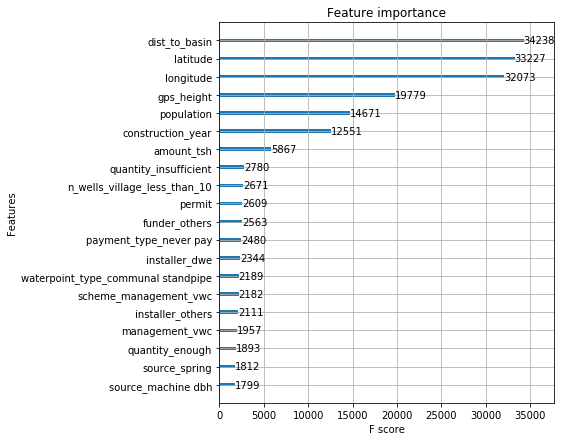

In [77]:
fig, ax = plt.subplots(figsize = (6, 7))
xgb.plot_importance(xgbc, max_num_features = 20, ax = ax)

In [19]:
# random forest gridsearch
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 5, 0.001], 
    'max_features': [3, 5, 10, 15], 
    'criterion': ['gini', 'entropy'], 
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(oob_score = True)

rf_g = GridSearchCV(rf, params, cv = 5, scoring = 'f1_weighted', verbose = 1, n_jobs = -1)
rf_g.fit(X_train_ohe, y_train)

print(rf_g.best_params_, ': ', rf_g.best_score_)

y_pred = rf_g.best_estimator_.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['rand_forest_gsc_1'] = (f1_test, acc_test)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 49.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 68.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 88.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 112.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 140.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 172.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 207.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 245.4min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed: 253.1min finished


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 150} :  0.6852358948077846
Test F1 score:  0.686 / Test Accuracy:  0.663


In [ ]:
# XGBoost_ gridsearch
params = {
    'eta': [0.001, 0.01, 0.1], 
    'max_depth': [3, 5, 7], 
    'min_child_weight': [0, 1, 10], 
    'subsample': [.5, .75, 1], 
}

xgbc = xgb.XGBClassifier(objective = 'multi:softmax')
xgbc_g = GridSearchCV(xgbc, params, cv = 5, scoring = 'f1_weighted', verbose = 1, n_jobs = -1)
xgbc_g.fit(X_train_ohe, y_train)

print(xgbc_g.best_params_, ': ', xgbc_g.best_score_)

y_pred = xgbc_g.best_estimator_.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper2['xgb_gsc_v1'] = (f1_test, acc_test)

mod = open('PKL/xgb_gsc_v1.pkl', 'wb')
pickle.dump(xgbc_g.best_estimator_, mod)
mod.close()